In [134]:
# Lasp module

import sys
sys.path.append('../../..')

import lasp.io
import lasp.filters.linear
import lasp.noise
import lasp.convert
import lasp.algorithm.experimental
import lasp.thresholding
import lasp.differential
import lasp.utils

# Other

import scipy.signal
import scipy.io.matlab
import numpy
import pandas
import tqdm
import pathlib
import matplotlib.pyplot
import typing
import yaml

# PATH = pathlib.Path('./5-MumfordShahFSR')
# if not(PATH.exists()):
#     PATH.mkdir()

In [135]:
import dataset

IMAGES_PATH = pathlib.Path('../0-Images')

GENERATION_PATH = pathlib.Path('./images-generated')
IMG_GEN_PKL = GENERATION_PATH / 'df_imgs.pkl'

OUTPUT_PATH = pathlib.Path('./outputs_1')
PARAMS_PKL = OUTPUT_PATH / 'df_params.pkl'

In [136]:
df_params = pandas.read_pickle(PARAMS_PKL)

with open(OUTPUT_PATH / 'metadatas.yml', 'w') as file:
    yaml.dump(df_params.attrs, file)
pandas.to_pickle(df_params, PARAMS_PKL)

print(df_params.attrs)
df_params

{'output_path': 'outputs_1'}


,df_imgs_index,deblur_kernel,alpha,beta0,beta1,sigma,iterations,tol
0,0,"(15, 5)",1,0.0,0.0,2,100,0
1,0,"(15, 5)",1,0.0,0.2,2,100,0
2,0,"(15, 5)",1,0.0,0.4,2,100,0
3,0,"(15, 5)",1,0.0,0.6,2,100,0
4,0,"(15, 5)",1,0.0,0.8,2,100,0
5,0,"(15, 5)",1,0.2,0.0,2,100,0
6,0,"(15, 5)",1,0.2,0.2,2,100,0
7,0,"(15, 5)",1,0.2,0.4,2,100,0
8,0,"(15, 5)",1,0.2,0.6,2,100,0
9,0,"(15, 5)",1,0.2,0.8,2,100,0


In [137]:
df_imgs = pandas.read_pickle(GENERATION_PATH / 'df_imgs.pkl')
with open(GENERATION_PATH / 'metadatas.yml', 'r') as file:
    df_imgs.attrs = yaml.safe_load(file)
print(df_imgs.attrs)
df_imgs

{'imgs_gen_path': 'images-generated'}


,original,blur,decimation,noise
0,../0-Images/Baboon.bmp,"(15, 5)",2,1000.0
1,../0-Images/Baboon.bmp,"(7, 3)",2,1000.0


In [138]:
df_to_process = df_imgs.join(df_params.set_index('df_imgs_index'))

# df_to_process = df_params_filtered.set_index('df_imgs_index').join(df_imgs)
df_to_process = df_to_process.dropna(how='any')
df_to_process = df_to_process.reset_index()
df_to_process.attrs.update(df_imgs.attrs)
df_to_process.attrs.update(df_params.attrs)
print(df_to_process.attrs)
df_to_process

output_path = pathlib.Path(df_to_process.attrs['output_path'])

{'imgs_gen_path': 'images-generated', 'output_path': 'outputs_1'}


/nix/store/dk781wbx225v5v2vj7dw4zwdi2p3mwp2-python3.10-pandas-1.4.2/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [139]:
import lasp.metrics


def compute_metrics(
    df_to_process: pandas.DataFrame, 
    index: int
) -> None:

    imgs_gen_path = pathlib.Path(df_to_process.attrs['imgs_gen_path'])
    output_path = pathlib.Path(df_to_process.attrs['output_path'])
    params = df_to_process.loc[index]
    # print(params.keys())

    df_imgs_index = params['index']

    original = lasp.io.read(
        imgs_gen_path / str(df_imgs_index) / 'original.npy'
    )

    # print(imgs_gen_path / str(df_imgs_index) / 'original.npy')
    # print(output_path / str(index) / 'output.npy')
    output = lasp.io.read(
        output_path / str(index) / 'output.npy'
    )
    

    return lasp.metrics.PSNR(original, output, intensity_max=255)


psnr_metrics: list[float] = []

for index in tqdm.tqdm(df_to_process.index):
   psnr_metrics.append(compute_metrics(df_to_process, index))

100%|██████████| 25/25 [00:00<00:00, 77.21it/s]


In [140]:

# print(value.shape)

beta0_inf, beta0_sup = 0, 1e-7
beta0_n = 5
beta0_step = (beta0_sup-beta0_inf) / beta0_n

beta1_inf, beta1_sup = 1e-3, 1e-4
beta1_n = 5
beta1_step = (beta1_sup-beta1_inf) / beta1_n

value = numpy.reshape(numpy.array(psnr_metrics), (beta0_n, beta1_n))

range_beta0 = numpy.arange(beta0_inf, beta0_sup, beta0_step)
range_beta1 = numpy.arange(beta1_inf, beta1_sup, beta1_step)

# print(axe_values.shape)
lines, cols = numpy.meshgrid(range_beta0, range_beta1)

In [141]:
print(value)

[[5.50076025 5.5034161  5.50235212 5.50110963 5.50037987]
 [5.50405126 5.50337986 5.50235378 5.5010955  5.50037802]
 [5.50412293 5.50334797 5.5023311  5.50106604 5.50037157]
 [5.50406719 5.50331852 5.50229827 5.50105137 5.50036378]
 [5.5039349  5.50329436 5.50228516 5.50102963 5.5003561 ]]


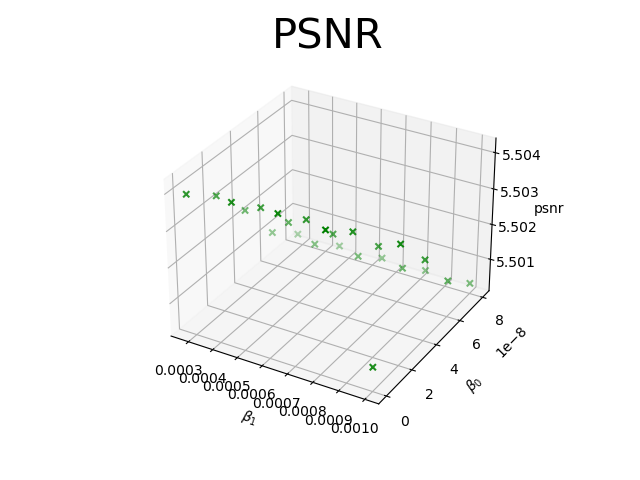

In [142]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget


# %matplotlib notebook 
# %matplotlib inline



import numpy

# import numpy as np



# Z_mae_plt: numpy.ndarray = mae

# coord_best: tuple[int, int] = i_mae, j_mae

# Set up a figure twice as tall as it is wide
fig = matplotlib.pyplot.figure()


# Graph 3D MSE

# ax = Axes3D(fig)
ax = fig.add_subplot(projection='3d')
# ax = Axes3D(fig)

x = cols.ravel()
y = lines.ravel()

## Display surface and points
# _ = ax.plot_surface(x, y, value, color='blue', alpha=0.1)
_ = ax.scatter(x, y, value, color='green', marker='x')

## Display best point
# s_color, s_spatial, mae = X_plt[coord_best], Y_plt[coord_best], Z_mae_plt[coord_best]
# _ = ax.scatter(s_color, s_spatial, mae, color='red', marker='o')
# ax.text(s_color, s_spatial, mae, '({:.3f}, {}, {:.3f})'.format(s_color, s_spatial, mae), color='red')

# setting title and labels
ax.set_title('PSNR', fontsize=30)
ax.set_xlabel('$\\beta_{1}$')
ax.set_ylabel('$\\beta_{0}$')
ax.set_zlabel('psnr')

# matplotlib.pyplot.plot(x, y, value)

# matplotlib.pyplot.savefig(output_path / 'graph3D.png')
matplotlib.pyplot.show()


In [143]:
beta0_inf, beta0_sup = 0, 1e-7
beta0_n = 5
beta0_step = (beta0_sup-beta0_inf) / beta0_n
print(numpy.arange(beta0_inf, beta0_sup, beta0_step))

[0.e+00 2.e-08 4.e-08 6.e-08 8.e-08]


In [144]:
10 * numpy.log10(255**2 / 1e4)

8.130803608679104